In [1]:
import os
import json
import pandas as pd
import time
import re
from collections import Counter
import random
import numpy as np
import tensorflow as tf

In [2]:
with open('config.json') as conf_file:
    config = json.load(conf_file)

In [3]:
def get_file_list(dataset):
    file_path_list = []
    for root, dirs, files in os.walk(config[dataset]):
         for file in files:
                file_path_list.append(os.path.join(root, file))

    print("file path list created, ", len(file_path_list), " files")
    return file_path_list



In [4]:
# Datasets:
# path_reuters_sample_5d  -- 5 Days of articles, 79 articles
# path_reuters_sample_1y -- 1y of articles, approx. 12k articles
# path_reuters  -- Full dataset +- approx. 100k articles

file_path_list = get_file_list('path_reuters')

file path list created,  106520  files


In [5]:
def preprocess_text(text):

    text = text.lower()
    #text = re.sub('[^a-z\d ]+', ' ', text) #remove special characters
    text = re.sub('[^a-z ]+', ' ', text) # replace with space to avoid concatenating words
    text = re.sub(' +', ' ', text) # remove multiple spaces
    # TODO: replace numbers with tag <NUMBER> instead of removing them
    return text
    
    

In [6]:
def read_reuters_pandas(file_path_list):
    reuters_articles = pd.DataFrame(columns=['Title','Author', 'Date', 'URL',  'Content'])

    start_t = time.time()
    for i, file_path in enumerate(file_path_list):
        if i%1000 == 0: 
            new_t = time.time()
            # print(i, " files loaded in ", new_t - start_t, " seconds")
            start_t = new_t
        with open(os.path.join(file_path), "r") as current_file:
                    data = current_file.readlines()
                    if len(data) < 4:
                        pass
                    else:
                        title= [preprocess_text(data[0])]
                        author = [re.sub('by', '', preprocess_text(data[1]))]
                        date = [data[2]]
                        url = [data[3]]
                        content = [" ".join(list(map(preprocess_text, data[4:len(data)])))]
                        data=list(map(preprocess_text, current_file.readlines()))
                        new_article = pd.DataFrame(data={'Title': title, 
                                                         'Author': author,
                                                         'Date': date, 
                                                         'URL': url,
                                                         'Content': content})
                        reuters_articles = reuters_articles.append(new_article)
    return reuters_articles

In [7]:
example_list_5d = get_file_list('path_reuters_sample_5d')
reuters_articles_example = read_reuters_pandas(example_list_5d)
reuters_articles_example.head()             

file path list created,  79  files


,Author,Content,Date,Title,URL
0,yereth rosen,anchorage alaska reuters exxon mobil xo...,"-- Fri Oct 20, 2006 6:15pm EDT\n",exxon mobil offers plan to end alaska dispute,-- http://www.reuters.com/article/2006/10/20/b...
0,eric auchard and paul thomasch,san francisco new york reuters wall str...,"-- Fri Oct 20, 2006 4:25pm EDT\n",hey buddy can you spare for a google share,-- http://www.reuters.com/article/2006/10/20/b...
0,,frankfurt reuters internet service prov...,"-- Sat Oct 21, 2006 2:21pm EDT\n",aol ceo says sales may shrink for two years p...,-- http://www.reuters.com/article/2006/10/21/b...
0,alister bull,washington reuters the central bank is ...,"-- Sun Oct 22, 2006 12:14pm EDT\n",fed to keep hawkish tone hold rates steady,-- http://www.reuters.com/article/2006/10/22/b...
0,,lima peru reuters argentine oil company...,"-- Sat Oct 21, 2006 8:11pm EDT\n",pluspetrol says losing mln day in peru protest,-- http://www.reuters.com/article/2006/10/22/b...


In [8]:
# code used to save a dataset with 1y of articles
# import pickle

# pickle.dump( reuters_articles, open( "reuters_articles.p", "wb" ) )

Checkpoint Dataset:

In [9]:
# code used to load a dataset with 1y of articles
# import pickle

# reuters_articles = pickle.load( open( "reuters_articles.p", "rb" ) )

# get wordcount


In [31]:
batch_size = 5000 #number of files to read at once.

wordcount = Counter()

for idx in range(0, len(file_path_list), batch_size):
    print(idx, " ", )
    file_path_sublist = file_path_list[idx:idx+batch_size]
    articles_df = read_reuters_pandas(file_path_sublist)
    
    word_list = "".join(articles_df['Content'].values).split() 
    wordcount = wordcount + Counter(word_list)

0  
0  files loaded in  0.0  seconds
1000  files loaded in  1.779325246810913  seconds
2000  files loaded in  1.650275468826294  seconds
3000  files loaded in  1.824927806854248  seconds
4000  files loaded in  1.9561526775360107  seconds
5000  
0  files loaded in  0.0  seconds
1000  files loaded in  1.5907280445098877  seconds
2000  files loaded in  1.6013784408569336  seconds
3000  files loaded in  1.7573275566101074  seconds
4000  files loaded in  1.9190444946289062  seconds
10000  
0  files loaded in  0.0  seconds
1000  files loaded in  1.5942027568817139  seconds
2000  files loaded in  1.7232568264007568  seconds
3000  files loaded in  1.7371394634246826  seconds
4000  files loaded in  1.9114067554473877  seconds
15000  
0  files loaded in  0.0  seconds
1000  files loaded in  1.649294376373291  seconds
2000  files loaded in  1.741816520690918  seconds
3000  files loaded in  1.8233976364135742  seconds
4000  files loaded in  1.969189167022705  seconds
20000  
0  files loaded in  0.0

IndexError: list index out of range

In [44]:
len(set(list(wordcount)))

120665

In [43]:
# saving wordcount after full load. Uncomment to overwrite
import pickle

#pickle.dump( wordcount, open( "reuters_wordcount.p", "wb" ) )

### Wordcount checkpoint

In [10]:
# code used to load a dataset with 1y of articles
import pickle
 
wordcount = pickle.load( open( "reuters_wordcount.p", "rb" ) )

In [11]:
wordcount["the"]

2807860

In [12]:
#Sub Sampling + removal of least common
def trim_vocabulary(wordcount, lower_bound = 10, threshold = 1e-5):
    # lower_bound = minimal occurences 
    # threshold = sub sampling threshold value
    
    print("Vocabulary size before trimming: ", len(wordcount.items()))

    total_count = sum(wordcount.values())

    freqs = {word: count/total_count for word, count in wordcount.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in wordcount}
    
    vocabulary = [word for word in list(wordcount) if wordcount[word] > lower_bound and random.random() < (1 - p_drop[word])]
    
    print("Vocabulary size before trimming: ", len(vocabulary))

    return vocabulary
    

In [13]:
vocabulary = trim_vocabulary(wordcount)

Vocabulary size before trimming:  120665
Vocabulary size before trimming:  38598


In [14]:
sorted_vocab = sorted(vocabulary, key=wordcount.get, reverse=True)
int_to_vocab = {idx: word for idx, word in enumerate(sorted_vocab)}
vocab_to_int = {word: idx for idx, word in int_to_vocab.items()}

int_words = [vocab_to_int[word] for word in vocabulary]

print("most common words: ", sorted_vocab[1:20])

most common words:  ['billion', 'up', 'also', 'growth', 'chief', 'world', 'now', 'investment', 'rose', 'crisis', 'trading', 'states', 'report', 'per', 'profit', 'long', 'demand', 'just', 'policy']


In [15]:
def get_train_words(vocabulary, vocab_to_int, file_path_list):
    articles_df = read_reuters_pandas(file_path_list)    
    word_list = "".join(articles_df['Content'].values).split()
    
    match_dict = {word: 1 for word in vocabulary} # waaaay more efficient than "if word in vocabulary"    
    train_words = [vocab_to_int[word] for word in word_list if match_dict.get(word, 0) == 1]
      
    # print("Total words in training set: ", len(train_words))
    # print("Unique words in training set: ", len(set(train_words)))
    
    return train_words

In [16]:
# random window size for target words
def target_words(word_vec, idx, window_size=10):
    rand_window = np.random.randint(1, window_size+1)
    start = max(0, idx - rand_window)
    stop = idx + rand_window
    target_words = set(word_vec[start:idx] + word_vec[idx+1:stop+1])
    
    return list(target_words)

In [17]:
# training batches from set of words
def word_batches(words, batch_size, window_size=5):
    
    n_batches = len(words)//batch_size
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = target_words(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

# Model architecture

In [18]:
n_vocab = len(int_to_vocab)
n_embedding = 200 
train_graph = tf.Graph()
n_sampled = 100

with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')
    
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [23]:
def train_function():
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = word_batches(train_words, word_batch_size, window_size)
        start = time.time()
        for x, y in batches:  
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)  
            loss += train_loss
            
            if iteration % 5000 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            iteration += 1

# Model Training
This can take long

In [24]:
epochs = 20
word_batch_size = 1000
window_size = 10
article_batch_size = 5000 #number of files to read at once.

tr_start_time = time.time()
with tf.Session(graph=train_graph) as sess:
    saver = tf.train.Saver()
    #train_words = get_train_words(vocabulary, vocab_to_int, file_path_list[0:article_batch_size])
    #train_function()
    #save_path = saver.save(sess, "checkpoints/text_full_reuters1.ckpt")
    for idx in range(0, len(file_path_list), article_batch_size):
        print("Article batch :", idx)
        file_path_sublist = file_path_list[idx:idx+article_batch_size]
        train_words = get_train_words(vocabulary, vocab_to_int, file_path_sublist)
        train_function()
        save_path = saver.save(sess, "checkpoints/text_full_reuters1.ckpt")


print("total training time:", time.time()-tr_start_time)


Article batch : 0
Epoch 12/20 Iteration: 5000 Avg. Training loss: 224.7854 0.1183 sec/batch


KeyboardInterrupt: 

1000


In [41]:
with train_graph.as_default():
    saver = tf.train.Saver()
with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    #saver.restore(sess,  "checkpoints/text8.ckpt")
    embed_mat = sess.run(embedding)
    

    

INFO:tensorflow:Restoring parameters from checkpoints\text_subsample.ckpt


In [74]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [75]:

viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

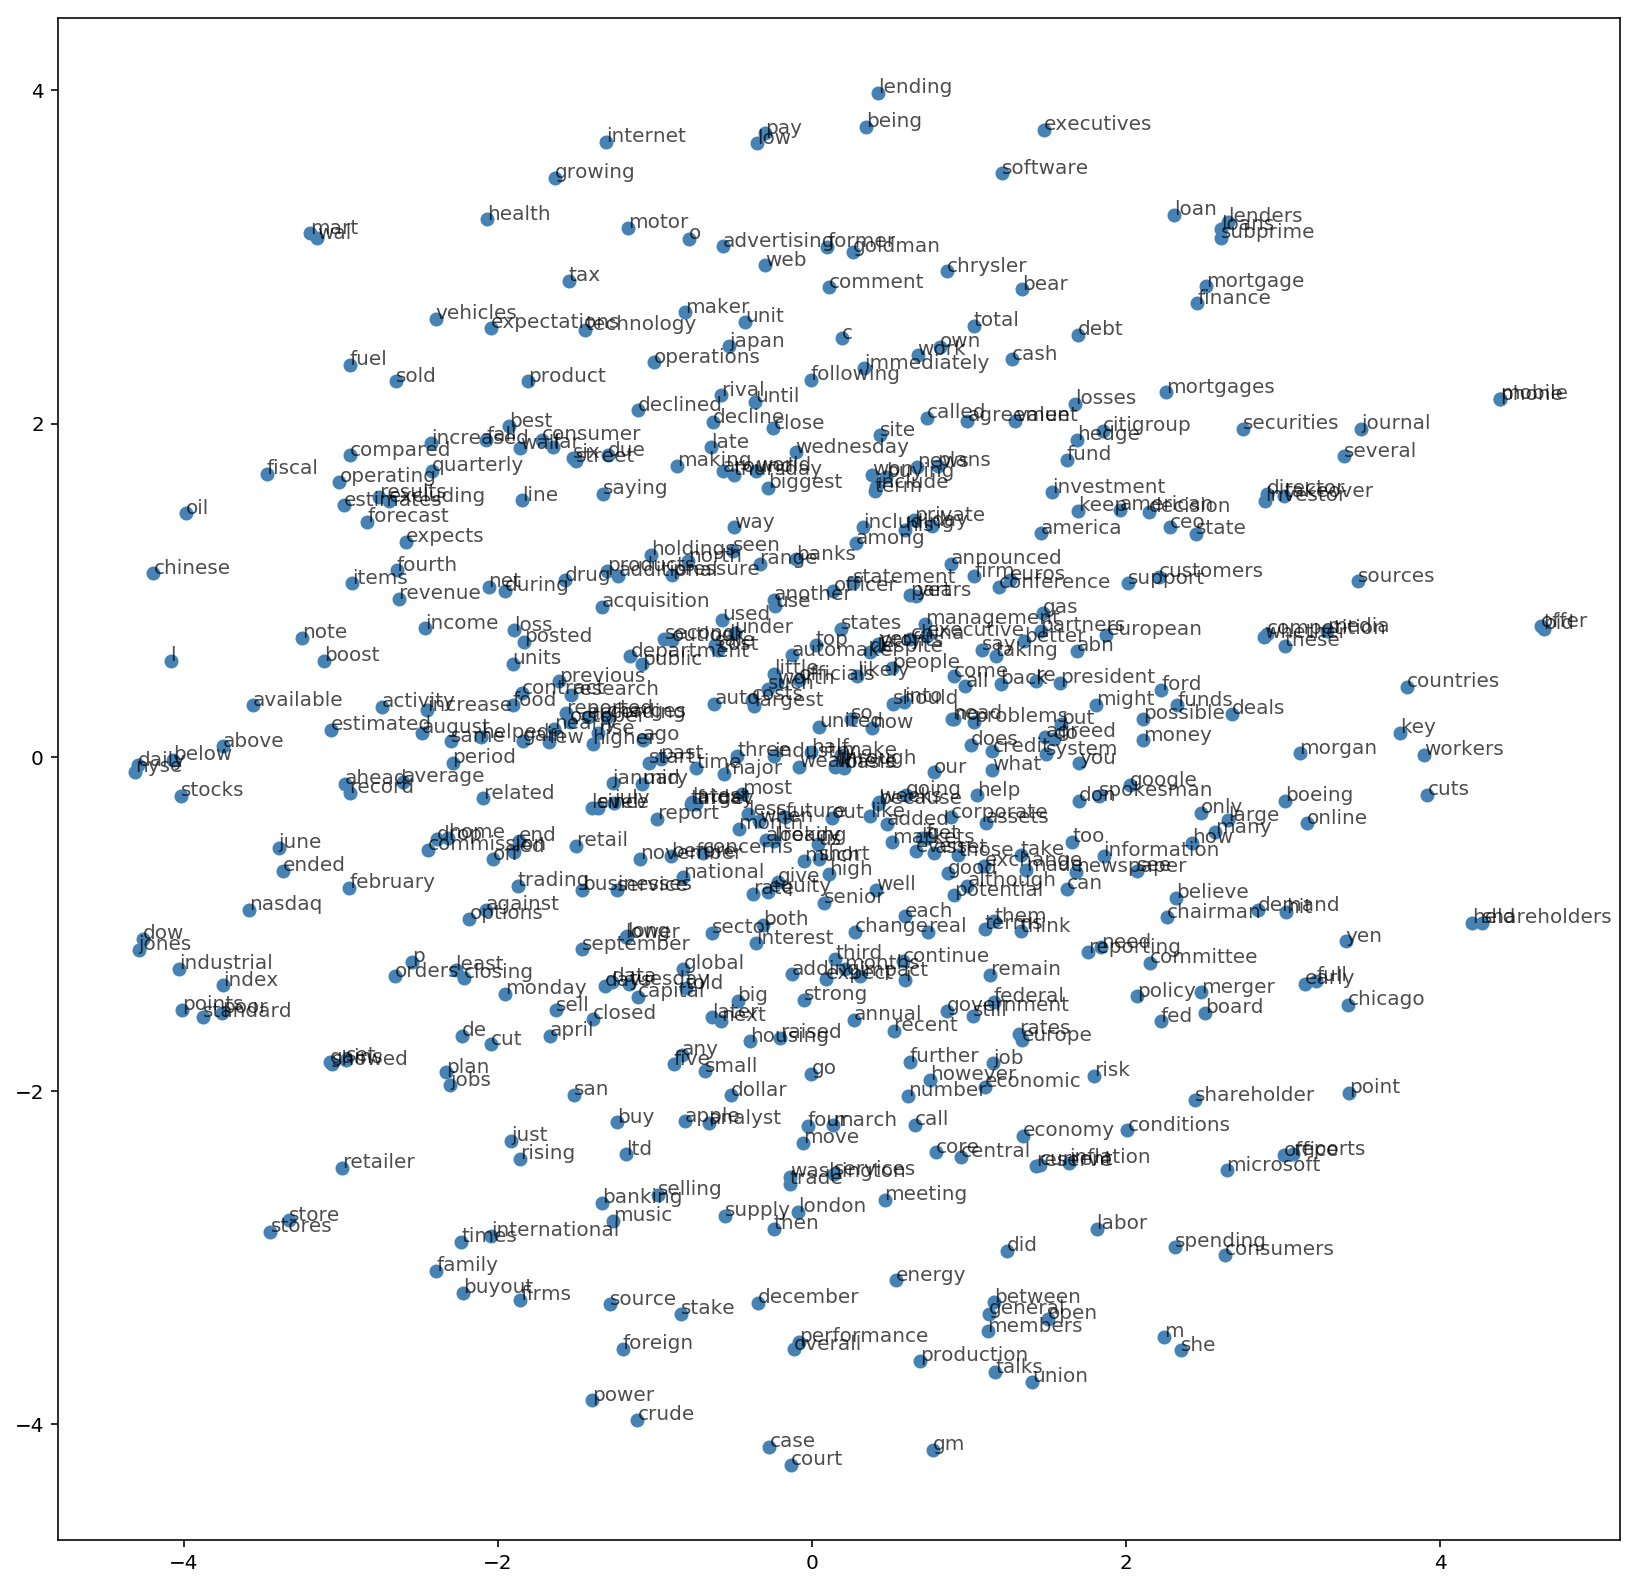

In [76]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [45]:
title_list = reuters_articles['Title'].values
title_list_words = [x.split() for x in title_list]
title_list_words

[['exxon', 'mobil', 'offers', 'plan', 'to', 'end', 'alaska', 'dispute'],
 ['hey', 'buddy', 'can', 'you', 'spare', 'for', 'a', 'google', 'share'],
 ['aol',
  'ceo',
  'says',
  'sales',
  'may',
  'shrink',
  'for',
  'two',
  'years',
  'paper'],
 ['fed', 'to', 'keep', 'hawkish', 'tone', 'hold', 'rates', 'steady'],
 ['pluspetrol', 'says', 'losing', 'mln', 'day', 'in', 'peru', 'protest'],
 ['eu', 'to', 'urge', 'china', 'to', 'open', 'economy', 'further'],
 ['daimlerchrysler', 'talks', 'to', 'firms', 'on', 'small', 'car', 'paper'],
 ['weatherford', 'profit', 'jumps', 'percent'],
 ['australia', 's', 'foster', 's', 'says', 'confident', 'on', 'targets'],
 ['update',
  'wal',
  'mart',
  'to',
  'slow',
  'u',
  's',
  'expansion',
  'spending',
  'growth'],
 ['ford', 'posts', 'biggest', 'loss', 'in', 'years'],
 ['ford', 'ceo', 'jury', 'out', 'on', 'european', 'premium', 'brands'],
 ['ford', 'won', 't', 'sell', 'ford', 'credit'],
 ['ford', 'is', 'reviewing', 'all', 'products', 'brands', 'ceo

In [46]:
def average_embeddings(word_list):
    int_word_list = [vocab_to_int.get(word, None) for word in word_list]
    embed_list = [embed_mat[idx] for idx in int_word_list if idx != None]
    return np.mean(embed_list, axis=0)
    

In [47]:
avg_embedding_vec = np.array(list(map(average_embeddings, title_list_words)))

In [55]:
from sklearn.cluster import KMeans

n_clusters= 4

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(avg_embedding_vec)
title_group = kmeans.labels_

[' daimlerchrysler talks to firms on small car paper ',
 ' ford won t sell ford credit ',
 ' shell looks to buy out canada unit for c billion ',
 ' royal dutch bid for shell canada low shareholder ',
 ' shell canada jumps pct on royal dutch offer ',
 ' private equity groups form for tribune bid source ',
 ' macquarie bids bln for metering firm techem ',
 ' countrywide laying off more than employees ',
 ' daimlerchrysler keeps outlook chrysler weighs ',
 ' gm signals it is closer to labor deal with delphi ',
 ' blackstone pai to buy united biscuits for bln ',
 ' int l paper to form jv with russia s ilim pulp ',
 ' analysts sound note of caution on gm cash burn ',
 ' capgemini to buy it firm kanbay intl for bln ',
 ' hannover re drops scottish re bid source says ',
 ' clear channel debt ratings may fall to junk ',
 ' united airlines raises fares in some markets ',
 ' hertz to sell million shares in ipo ',
 ' cemex offers to buy rinker for billion ',
 ' tse says in tie up talks with nyse 

In [67]:
n_titles_print = 6

for idx_a in range(n_clusters):
    print("examples of titles for group ", idx_a+1)
    titles_cluster = [title for idx_b, title in enumerate(title_list) if title_group[idx_b] == idx_a ]
    rand_select_title = np.take(titles_cluster, np.random.choice(len(titles_cluster), n_titles_print))
    for title in rand_select_title:
        print(title)


examples of titles for group  1
 sony playstation debuts amid shopper frenzy 
 best buy circuit city raise outlooks on dec sales 
 eds net profit surges stock down on outlook 
 toll bros home building sales fall top estimates 
 barr quarterly earnings down on charges 
 motorola reshuffles its business units 
examples of titles for group  2
 major dow jones shareholder opposes news corp bid 
 arcelormittal gets u s ok for sparrows point sale 
 eddie bauer agrees to be bought for million 
 private equity buys txu in record deal 
 corrected sallie mae sues buyer group to stick to deal terms 
 electronic arts to buy stake in the report 
examples of titles for group  3
 correction fed cut rates to offset credit crunch kroszner 
 china must keep real interest rates positive ndrc 
 pending home sales fell pct in august 
 oil rises on opec jitters after pct slide 
 new home sales rise pct in march 
 big oil says not to blame for high gasoline prices 
examples of titles for group  4
 eads await